In [1]:
from datahandler import DataHandler
from models.unet import *
from generator import *
from params import *
from callbacks import getCallbacks

from tqdm import tqdm
import os
import skimage.io as io

from keras.models import *
from keras import backend as K

%matplotlib inline
import matplotlib.pyplot as plt

import argparse
import sys

Using TensorFlow backend.


In [2]:
#set common variables
epochs = 25
batch_size = 32
verbose = 1


resetSeed()

In [3]:
#Get data and generators
dh = DataHandler()
tr_images, tr_masks, te_images, te_masks = dh.getData()

Validation data: 100%|██████████████████████████| 43/43 [00:48<00:00,  1.10s/it]


In [127]:
model = getUnet()
model.load_weights('logs/unet/kfold_unet/kfold_unet_dice_DA_K2/kfold_unet_dice_DA_K2_weights.h5')

In [128]:
image = np.expand_dims(tr_images[100], axis=0)
res1 = model.predict(image)

image = np.expand_dims(tr_images[101], axis=0)
res2 = model.predict(image)

image = np.expand_dims(tr_images[102], axis=0)
res3 = model.predict(image)


In [129]:
res = np.concatenate((res1,res2,res3))
print(res.shape)

(3, 256, 256, 1)


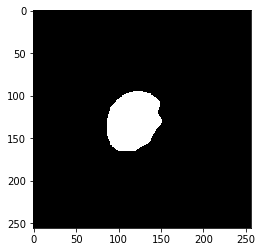

In [130]:
mask = tr_masks[101]
plt.imshow(np.squeeze(mask))


In [131]:
print(res.shape)
print(mask.shape)

(3, 256, 256, 1)
(256, 256, 1)


In [132]:
from keras.models import Model
from keras.layers import Input, MaxPooling2D, Dropout, Conv2D, Conv2DTranspose, TimeDistributed, Bidirectional, ConvLSTM2D


inputs = Input((3, 256, 256, 1))

bclstm = Bidirectional(ConvLSTM2D(32, 3, return_sequences = True, padding='same', activation = 'relu'))(inputs)
bclstm = Bidirectional(ConvLSTM2D(32, 3, return_sequences = True, padding='same', activation = 'relu'))(bclstm)

pool = TimeDistributed(MaxPooling2D(pool_size=2))(bclstm)

bclstm = Bidirectional(ConvLSTM2D(64, 3, return_sequences = True, padding='same', activation = 'relu'))(pool)
bclstm = Bidirectional(ConvLSTM2D(64, 3, return_sequences = True, padding='same', activation = 'relu'))(bclstm)
bclstm = Bidirectional(ConvLSTM2D(64, 3, padding='same', activation = 'relu'))(bclstm)

up = Conv2DTranspose(64,3, strides=2, padding='same', activation = 'relu')(bclstm)
conv = Conv2D(64, 3, activation = 'relu', padding='same')(up)

outputs = Conv2D(1, (1,1), activation = 'sigmoid')(conv)

model = Model(input = inputs, output = outputs)

print(model.summary())
print(model.output_shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3, 256, 256, 1)    0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 3, 256, 256, 64)   76288     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 3, 256, 256, 64)   221440    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 3, 128, 128, 64)   0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 3, 128, 128, 128)  590336    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 3, 128, 128, 128)  885248    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128, 128, 128)     885248    
__________

/home/alejandrovaldes/.virtualenvs/fetal-brain-segmentation-9O2pP5m0/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [133]:
from keras.optimizers import RMSprop, Adam, SGD
from keras.losses import binary_crossentropy
from losses import bce_dice_loss

model.compile(optimizer = Adam(lr = 1e-4),
            loss = binary_crossentropy, metrics = [dice_coef])

In [152]:
model.fit(np.expand_dims(res, axis=0), np.expand_dims(mask, axis=0), epochs=30, verbose=1)

Epoch 1/30
1/1 [==============================] - 0s 288ms/step - loss: -13.3184 - dice_coef: 1.4050
Epoch 2/30
1/1 [==============================] - 0s 269ms/step - loss: -17.6748 - dice_coef: 1.5040
Epoch 3/30
1/1 [==============================] - 0s 272ms/step - loss: -23.7240 - dice_coef: 1.6091
Epoch 4/30
1/1 [==============================] - 0s 274ms/step - loss: -32.3140 - dice_coef: 1.7077
Epoch 5/30
1/1 [==============================] - 0s 272ms/step - loss: -44.8823 - dice_coef: 1.7855
Epoch 6/30
1/1 [==============================] - 0s 272ms/step - loss: -63.9345 - dice_coef: 1.8360
Epoch 7/30
1/1 [==============================] - 0s 275ms/step - loss: -94.0513 - dice_coef: 1.8642
Epoch 8/30
1/1 [==============================] - 0s 275ms/step - loss: -140.0333 - dice_coef: 1.8794
Epoch 9/30
1/1 [==============================] - 0s 273ms/step - loss: -174.4283 - dice_coef: 1.8871
Epoch 10/30
1/1 [==============================] - 0s 271ms/step - loss: -189.2296 - dice

In [158]:
print(res.shape)
r = model.predict(np.expand_dims(res, axis=0))
print(r.shape)
r[r>=0.7] = 255
r[r<0.7] = 0

(3, 256, 256, 1)
(1, 256, 256, 1)


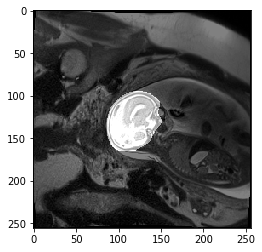

In [154]:
plt.gray()

plt.imshow(np.squeeze(tr_images[101] + tr_masks[101]))

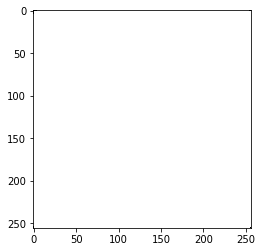

In [159]:
plt.imshow(np.squeeze(r))

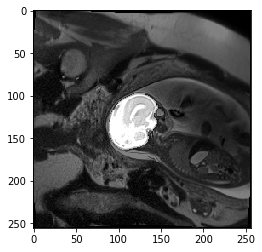

In [126]:
plt.imshow(np.squeeze(tr_images[101] + res2 * 255))